In [1]:
import numpy as np
import seaborn as sb
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from pyrosetta import *
from pyrosetta.toolbox import cleanATOM

init()

PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2021.25+release.a320e4cf1992c9ab57f47bff2a13fed0a86831f5 2021-06-24T12:29:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: {0} Checking for fconfig files in pwd and ./rosetta/flags
core.init: {0} Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release r287 2021.25+release.a320e4c a320e4cf1992c9ab57f47bff2a13fed0a86831f5 http://www.pyrosetta.org 2021-06-24T12:29:25
core.init: {0} command: PyRosetta -ex1 -ex2aro -database /home/ben/miniconda3/envs/PyRosetta.notebooks/lib/python3.7/site-packages/pyrosetta/database
basic.random.init_random_generator: {0} 'RNG device' seed mode, using '/dev/urandom', seed=282663980 seed_offset=0 real_seed=282663980 thread_index=0
basic.random.init_random_generator: {0} RandomGenerator:init: Normal mode, seed=282663980 

# Network Analysis of Staphylococcal Nuclease
* Nodes represent residues
* Edges represent residue sidechain interactions
* Edge weights are obtained from [Brinda & Vishveshwara (2005)](https://www.cell.com/biophysj/fulltext/S0006-3495(05)73057-5#relatedArticles) and calculated as follows:

$$
I_{ij} = (\frac{n_{ij}}{N_i \times N_j}) \times 100
$$

where $n_{ij}$ is the number of atoms within 4.5 angstroms of a residue and $N_i$ is the Normalization Value as reported in the supplementary information of the paper.

* This network is therefore weighted and undirected

The goal of this analysis is to cluster the residue interactions with the goal of identifying residues that form stabilizing interactions and to identify the residues within those clusters that contribute the most and least to the cluster stability. Once such clusters are identified, I will use Rosetta to calculate the energy difference of the presence and absence of that side chain to see how well the network model does at predicting the contributions of these interactions.

## Create The Network
### Relax the Input Protein

This takes a really long time (depending on the input protein size and only needs to be run once.

Doing this relaxes the side chains using the rosetta energy function and ensures more natural side chain interactions are present compared to the orientations reported in the PDB file.

From my testing this creates larger clusters.

I am omitting this step from the notebook since it doesn't necessarily have to do with the analysis and takes forever but here is how the code would be run if you're curious:

``` python
before_relax = pose_from_pdb("3bdc.pdb")
from rosetta.protocols.relax import FastRelax
fr = FastRelax()
fr.set_scorefxn(rosetta.core.scoring.get_score_function())
fr.apply(before_relax)
pose.dump_pdb("snase_relaxed.pdb")
```

### Load in the relaxed protein as a new PyRosetta pose object

In [3]:
pose = pose_from_pdb("snase_relaxed.pdb")

core.chemical.GlobalResidueTypeSet: {0} Finished initializing fa_standard residue type set.  Created 984 residue types
core.chemical.GlobalResidueTypeSet: {0} Total time to initialize 1.16834 seconds.
core.import_pose.import_pose: {0} File 'snase_relaxed.pdb' automatically determined to be of type PDB


### Construct a dictionary that maps each residue to a list of its sidechain atoms

In [4]:
r_coord_dict = {}
# Loop over all resiudes in the protein
for res in range(1, pose.size()+1):
    r = pose.residue(res)
    #Seclect only side chain atoms
    atom_coords = [np.array(r.xyz(atom)) for atom in range(1, r.natoms()+1) if atom not in list(r.all_bb_atoms()) and not r.atom_is_hydrogen(atom)]
    r_coord_dict[res] = np.array(atom_coords)

In [5]:
# Counts the number of atoms within interaction distance of 4.5 angstroms
def within_interaction_distance(resi1, resi2):
    ctr = 0 
    for i in resi1:
        for j in resi2:
            if (i[0] - j[0])**2 + (i[1] - j[1])**2 + (i[2] - j[2])**2 <= 4.5**2:
                ctr = ctr + 1
    return ctr

### Calculate the Non-Covalent Interaction Weight Between Side Chain Nodes

In [6]:
%%time
I_min = 0 #Adjustable interaction strength percentage, default to zero for now.

norm_values = {"ALA":55.76, "ARG":93.79, "ASN":73.41, "ASP":75.15, "CYS":54.95, "GLN":78.3, "GLU":78.83, "GLY":47.31, "HIS":83.74, "ILE":67.95, "LEU":72.25, "LYS":69.61, "MET":69.26, "PHE":93.31, "PRO":51.33, "SER":61.39, "THR":63.71, "TRP":106.70, "TYR":100.72, "VAL":62.37}
interaction_mtx = np.zeros((pose.size(), pose.size()))
for i in range(pose.size()):
    for j in range(i+1, pose.size()):
        n_ij = within_interaction_distance(r_coord_dict[i+1], r_coord_dict[j+1])
        N_i = norm_values[pose.residue(i+1).name3()]
        N_j = norm_values[pose.residue(j+1).name3()] 
        I_ij = (n_ij / np.sqrt(N_i * N_j)) * 100 #Equation 1 from paper
        interaction_mtx[i, j] = I_ij if I_ij > I_min else 0 #Only take interactions above I_min
interaction_mtx = interaction_mtx.T + interaction_mtx

CPU times: user 354 ms, sys: 340 µs, total: 354 ms
Wall time: 353 ms


### Display Symmetrized Interaction Matrix and Graph Structure

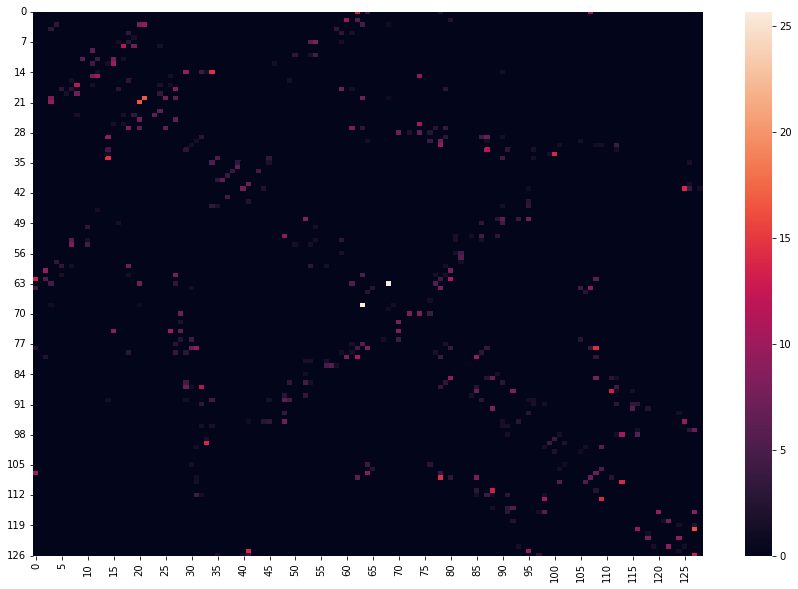

In [7]:
sb.heatmap(interaction_mtx);
plt.gcf().set_size_inches(15,10)
plt.savefig("SNase_raw_adjacency_mtx.png")

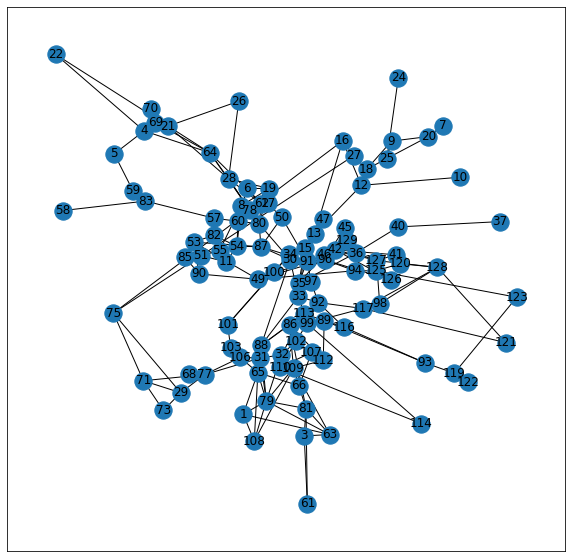

In [8]:
from graspologic.utils import largest_connected_component

G = nx.Graph(interaction_mtx)
mapping = {i-1:i for i in list(range(1, pose.size()+1))}
G = nx.relabel_nodes(G, mapping)

pos = nx.kamada_kawai_layout(largest_connected_component(G))
fig, ax = plt.subplots(1, 1)
nx.draw_networkx(largest_connected_component(G), pos=pos, ax=ax, with_labels=True)
plt.gcf().set_size_inches(10,10)
plt.savefig("snase_network_plot.png")

## Count the number of nodes and edges

In [9]:
print(f"This graph has {len(G.nodes())} nodes and {len(G.edges())} edges")

This graph has 129 nodes and 209 edges


## Apply Leiden Clustering to Interaction Network

In [10]:
from graspologic.partition import leiden, modularity
from graspologic.plot import networkplot, heatmap

def plot_network_partition(adj, node_data, partition_key):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    networkplot(
        adj,
        x="x",
        y="y",
        node_data=node_df.reset_index(),
        node_alpha=0.9,
        edge_alpha=0.7,
        edge_linewidth=0.4,
        node_hue=partition_key,
        node_size="degree",
        edge_hue="source",
        ax=axs[0],
    )
    _ = axs[0].axis("off")

    _ = heatmap(
        adj,
        inner_hier_labels=node_data[partition_key],
        ax=axs[1],
        cbar=False,
        cmap="Purples",
        vmin=0,
        center=None,
        sort_nodes=True,
    )

    return fig, ax


leiden_partition_map = leiden(G, trials=100, random_seed=18218)
modularity(G, leiden_partition_map)

/home/ben/miniconda3/envs/PyRosetta.notebooks/lib/python3.7/site-packages/graspologic/partition/leiden.py:355: UserWarning: Leiden partitions do not contain all nodes from the input graph because input graph contained isolate nodes.
  "Leiden partitions do not contain all nodes from the input graph because input graph "


0.7640684130314405

### Plot the clustering results

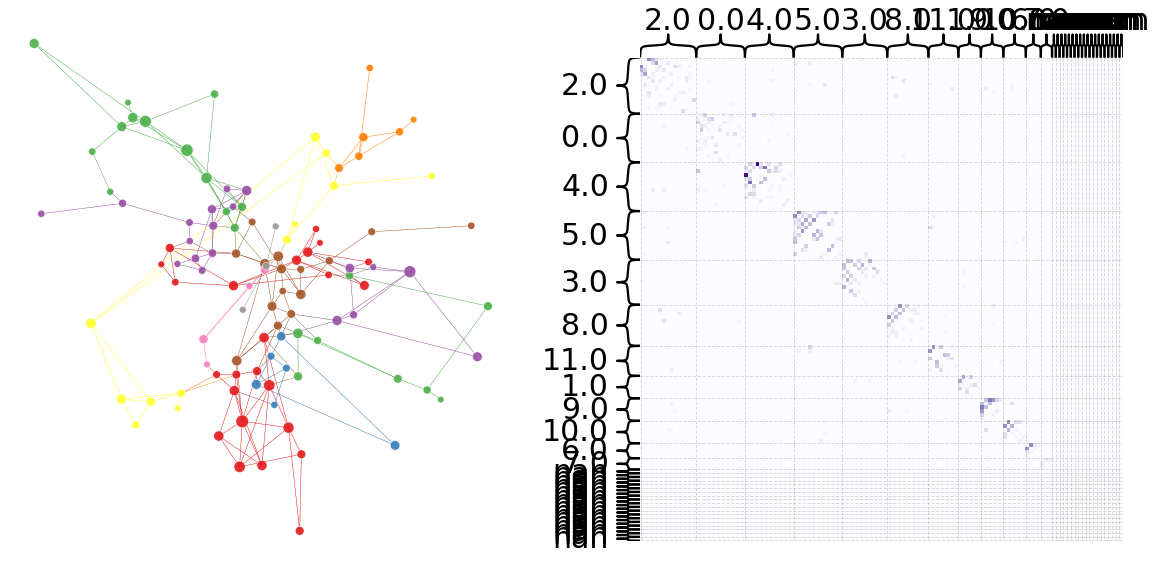

In [11]:
nodelist = list(G.nodes)
node_df = pd.DataFrame(index=nodelist)
pos = nx.kamada_kawai_layout(G)

xs = []
ys = []
for node in nodelist:
    xs.append(pos[node][0])
    ys.append(pos[node][1])
xs = np.array(xs)
ys = np.array(ys)
adj = nx.to_numpy_array(G, nodelist=nodelist)
n = adj.shape[0]

node_df["degree"] = adj.sum(axis=0)

node_df["x"] = xs
node_df["y"] = ys
node_df['leiden_partition'] = node_df.index.map(leiden_partition_map)
plot_network_partition(adj, node_df, 'leiden_partition')
plt.gcf().set_size_inches(20,10)
plt.savefig("snase_leiden_clustering.png")

Sort the clusters by size to analyze for most essential residues

In [12]:
idx_to_count = []
for i in range(max(leiden_partition_map.values()) + 1):
    idx_to_count.append((i, [x for x in leiden_partition_map.values()].count(i)))
                        
idx_to_count.sort(key=lambda x : x[1], reverse=True)
partitions = [x[0] for x in idx_to_count]

Output PyMol (macromolecular visualization software) selection commands for each cluster to make visualization of result easier. Images of the respective visualization commands are included below. Color in these images is conserved in later visualizations of results as well.

In [13]:
for part in partitions[:5]:
    print("select resi ", end="")
    for i in [x for x,j in leiden_partition_map.items() if j == part]:
        print(f"{pose.pdb_info().pose2pdb(i).split()[0]}+", end="")
    print()

select resi 62+39+99+104+21+103+43+58+125+100+109+42+41+52+36+
select resi 67+14+66+63+70+69+72+12+94+25+17+95+23+
select resi 82+90+27+10+81+34+74+28+32+11+76+71+92+
select resi 93+7+37+118+38+75+98+77+9+120+91+73+121+
select resi 22+16+35+83+80+87+89+85+59+18+19+33+


![cluster 1](../images/fry_cluster_1.png)
![cluster 2](../images/fry_cluster_2.png)
![cluster 3](../images/fry_cluster_3.png)
![cluster 4](../images/fry_cluster_4.png)
![cluster 5](../images/fry_cluster_5.png)

## Identify the nodes in each cluster with the highest and lowest respective degree centralities
Also, generate plots for each subgraph obtained from the leiden clusters

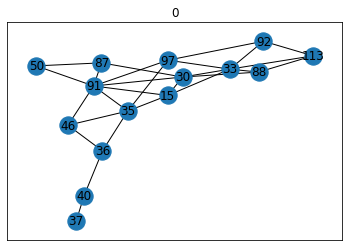

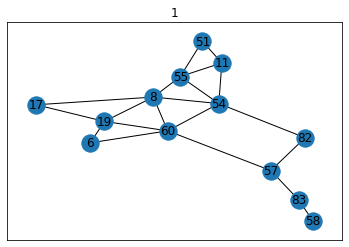

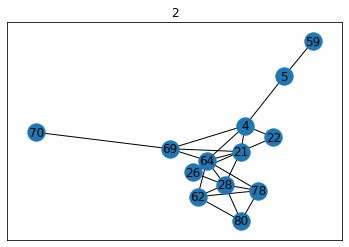

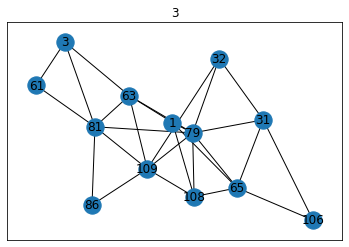

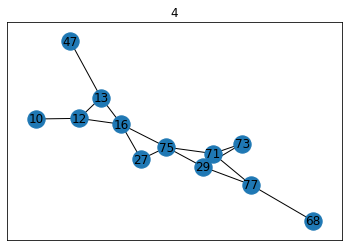

In [14]:
partitions = partitions[:5]
colors = ["r", "b", "g", "y", "m"]
color_map = {str(x):y for x,y in zip(partitions, colors)}

highest_centralities = []
lowest_centralities = []
for i,k in enumerate(partitions):
    plt.figure(i)
    G_1 = G.subgraph([x for x,j in leiden_partition_map.items() if j == k])
    nx.draw_networkx(G_1)
    
    nodes_by_degree = sorted(G_1.degree(), key=lambda x : x[1], reverse=True)
    highest_centralities.append(nodes_by_degree[0][0])
    lowest_centralities.append(nodes_by_degree[-1][0])
    
    
    plt.gca().set_title(f"{i}")
    plt.gcf().set_facecolor("#FFFFFF")
    plt.savefig(f"snase_leiden_{i}.png")
    plt.show()

## Create A Network Embedding To Compare to Leiden Clustering Results

In [15]:
from umap import UMAP
from graspologic.embed import node2vec_embed
from graspologic.utils import largest_connected_component

g = largest_connected_component(G)
adj = nx.to_numpy_matrix(g)
node2vec_embedding, node_ids = node2vec_embed(g, dimensions=100, num_walks=10, walk_length=16, inout_hyperparameter=1.0, return_hyperparameter=1.0, random_seed=8888)
reindexed_interaction_mtx = interaction_mtx[np.array([x-1 for x in node_ids])]
reindexed_interaction_mtx = reindexed_interaction_mtx[:, np.array([x-1 for x in node_ids])]
umapper = UMAP(metric="cosine", min_dist=0.8, random_state=888, n_components=3)
umap_node2vec_embedding = umapper.fit_transform(node2vec_embedding)

In [16]:
from graspologic.plot import networkplot
df = pd.DataFrame(index=list(g.nodes()))
df['umap_01'] = umap_node2vec_embedding[:, 0]
df['umap_02'] = umap_node2vec_embedding[:, 1]
df['umap_03'] = umap_node2vec_embedding[:, 2]
df['label'] = np.array([leiden_partition_map[x] for x in list(g.nodes())]).astype(str)
df['degree'] = np.array(np.sum(reindexed_interaction_mtx, axis=1))
print("Number of connected Nodes: ", df.shape[0])

# Only want to visualize the data that is in the partitions that we are looking at. 
df = df[df["label"].isin(str(x) for x in partitions)]
print("Number of connected nodes in the first 5 identified clusters: ", df.shape[0])

indices = list(df.index.values)
index_to_posenum_map = {idx:x for idx, x in enumerate(indices)}
cluster_only_interaction_mtx = interaction_mtx[[x-1 for x in indices]]
cluster_only_interaction_mtx = cluster_only_interaction_mtx[:, [x-1 for x in indices]]

Number of connected Nodes:  107
Number of connected nodes in the first 5 identified clusters:  66


### Plot Network Embedding

Note good separation between colors. Color is by leiden cluster. Notably, the red cluster appears to fall between the blue, yellow, and magenta clusters. This is as expected as these residues are spatially situated between the other clusters in the protein structure.

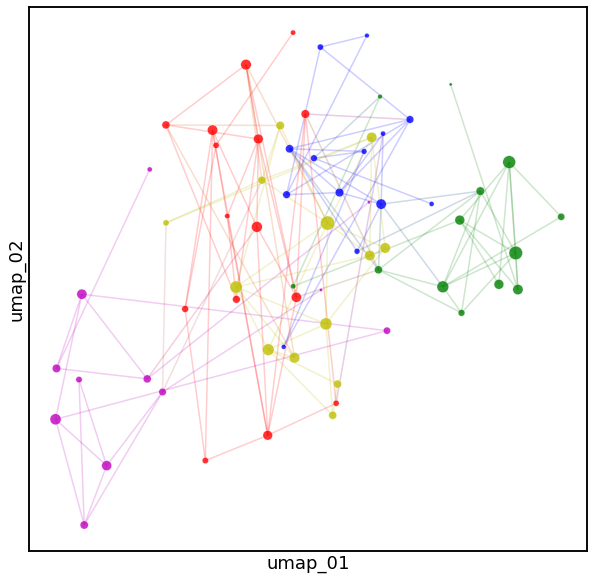

In [17]:
networkplot(
    cluster_only_interaction_mtx,
    x="umap_01",
    y="umap_02",
    node_data=df.reset_index(),
    node_hue="label",
    palette=color_map,
    node_size="degree",
    node_sizes=(10,200),
    edge_linewidth=1.5,
    edge_alpha=0.1,
)
plt.gcf().set_size_inches(10,10)
plt.gcf().set_facecolor("#FFFFFF")
plt.savefig("snase_embedding.png")

## Apply Rosetta minimization packing to Obtain Energy Differences
Mutates high and low centrality residues to Glycine (an amino acid with no side chain for interactions) for comparison of how centrality correlates with stabilizing activity.

In [18]:
from pyrosetta.rosetta.core.select import residue_selector
from pyrosetta.rosetta.protocols import minimization_packing

#Takes in a 1-indexed protein residue, mutates to glycine, and returns the energy difference
def mutate_to_glycine(residue_to_repack):
    pose_copy = pose.clone()

    # Write the resfile header
    resfile = "NATRO\n"
    resfile += "USE_INPUT_SC\n"
    resfile += "start\n"

    sfxn = get_fa_scorefxn()
    prior_score = sfxn(pose_copy)

    nbr_selector = residue_selector.NeighborhoodResidueSelector()
    # Select the residue of interest, by making boolean list by index
    resn_vector = [x == residue_to_repack for x in range(pose_copy.size())]
    nbr_selector.set_focus(pyrosetta.Vector1(resn_vector))
    nbr_selector.set_include_focus_in_subset(True)
    # Apply to neigh. res. selector for 6 angst radius selection
    nbr_selector.set_distance(6)
    selection_vector = nbr_selector.apply(pose_copy)

    # Loop through selection vector and add each procedure to resfile
    tail = "USE_INPUT_SC EX 1 LEVEL 4 EX 2 LEVEL 4 EX 3 LEVEL 1 EX 4 LEVEL 1 EX_CUTOFF 1\n"

    for i, j in enumerate(list(selection_vector)):
        position_and_chain = pose_copy.pdb_info().pose2pdb(i+1)
        if i == residue_to_repack - 1:  # Mutate i to ASN.
            resfile += f"{position_and_chain} PIKAA N " + tail
        elif j == 1:  # Relax any neighbors without mutation.
            resfile += f"{position_and_chain} NATAA " + tail

    resfile_name = "snase_mutation.res"
    with open(resfile_name, "w") as f:
        f.write(resfile)

    # Apply mutation and packing
    tf = pyrosetta.rosetta.core.pack.task.TaskFactory()
    tf.push_back(pyrosetta.rosetta.core.pack.task.operation.ReadResfile(resfile_name))
    packer_task = tf.create_task_and_apply_taskoperations(pose_copy)
    designmover = minimization_packing.PackRotamersMover(sfxn, packer_task)
    designmover.apply(pose_copy)
    
    post_score = sfxn(pose_copy)
    energy_difference = post_score - prior_score
    return energy_difference

### Record the energy difference of the highest centrality residue mutations to glycine

In [21]:
energy_diff_map = {x : mutate_to_glycine(x) for x in highest_centralities}
print()
for idx, (i,j) in enumerate(energy_diff_map.items()):
    print(f"Cluster {idx + 1} - Highest Degree Node Energy Difference:", pose.pdb_info().pose2pdb(i), j)

core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.pack.pack_rotamers: {0} built 3542 rotamers at 8 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.pack.pack_rotamers: {0} built 7067 rotamers at 6 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating LinearMemoryInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.pack.pack_rotamers: {0} built 6

### Repeat with the lowest centrality residue mutations to glycine


In [22]:
energy_diff_map = {x : mutate_to_glycine(x) for x in lowest_centralities}
print()
for i,j in energy_diff_map.items():
    print(f"Cluster {idx + 1} - Lowest Degree Node Energy Difference:", pose.pdb_info().pose2pdb(i), j)

core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.pack.pack_rotamers: {0} built 821 rotamers at 4 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.pack.pack_rotamers: {0} built 6227 rotamers at 4 positions.
core.pack.pack_rotamers: {0} Requesting all available threads for interaction graph computation.
core.pack.interaction_graph.interaction_graph_factory: {0} Instantiating PDInteractionGraph
core.pack.rotamer_set.RotamerSets: {0} Completed interaction graph pre-calculation in 1 available threads (1 had been requested).
core.scoring.ScoreFunctionFactory: {0} SCOREFUNCTION: ref2015
core.pack.pack_rotamers: {0} built 1195 rotamer

## Discussion
Note the lower difference in energy for lower centrality nodes. Since we are measuring the free energy in Rosetta Energy Units (REU). A higher energy difference indicates that the mutant protein is less stable. A lower energy difference is more stable. These data show that lower centrality nodes are more amenable to design and mutation to other residues than higher centrality nodes.

Therefore, I conclude that degree centrality applied to protein network models can be used to identify residues that contribute to protein structure stabilization.